<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br><b>Introduction to the DP0.3</b> <br>
Contact author(s): Bob Abel and Douglas Tucker<br>
Last verified to run: 2023-07-09 <br>
LSST Science Piplines version: Weekly 2023_21 <br>
Container size: medium <br>
Targeted learning level: beginner <br>

In [ ]:
%load_ext pycodestyle_magic
%flake8_on
import logging
logging.getLogger("flake8").setLevel(logging.FATAL)

**Description:** An overview of the contents of the DP0.3 moving object catalogs.

**Skills:** Use the TAP service and ADQL to access the DP0.3 tables.

**LSST Data Products:** TAP dp03_catalogs.

**Packages:** `lsst.rsp.get_tap_service`

**Credit:**
Mario Jurić provided essential assistance in the initial stages of creating this notebook.  The notebook authors would also like to acknowledge help from Leanne Guy, Pedro Bernardinelli, Sarah Greenstreet, Megan Schwamb, Brian Rogers, Niall McElroy, and Jake Vanderplass, among others.

**Get Support:**
Find DP0.3-related documentation and resources at <a href="https://dp0-3.lsst.io">dp0-3.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook demonstrates how to access the simulated Data Preview 0.3 (DP0.3) data set in the Rubin Science Platform.

For the DP0.3 simulation, only moving objects were simulated, and only catalogs were created (there are no images).
The DP0.3 simulation is *entirely independent of and separate from* the DP0.2 simulation.

DP0.3 is a hybrid catalog that contains both real and simulated Solar System objects (asteroids, near-earth objects, Trojans, trans-Neptunian objects, and even a simulated spaceship... but no comets, major planets, or the Moon).
See the <a href="https://dp0-3.lsst.io">DP0.3 documentation</a> for more information about how the hybrid catalog was created.

In Rubin Operations, these tables would be constantly changing, updated every day with the results of
the previous night's observations.
However, for DP0.3, a static 10-year catalog has been simulated.

### 1.1. Package Imports

Import general python packages and the Rubin TAP service utilities.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.patches import Rectangle
import pandas as pd
from lsst.rsp import get_tap_service

## 2. Create the Rubin SSO TAP Service client

The DP0.3 data sets are available via the Table Access Protocol (TAP) service,
and can be accessed with ADQL (Astronomical Data Query Language) statements.

TAP provides standardized access to catalog data for discovery, search, and retrieval.
Full <a href="http://www.ivoa.net/documents/TAP">documentation for TAP</a> is provided by the International Virtual Observatory Alliance (IVOA).
ADQL is similar to SQL (Structured Query Langage).
The <a href="http://www.ivoa.net/documents/latest/ADQL.html">documentation for ADQL</a> includes more information about syntax and keywords.

Get an instance of the SSO TAP service, and assert that it exists.

> **Notice:** The DP0.3 TAP service is called `ssotap` (whereas `tap` is used for DP0.2).

In [2]:
service = get_tap_service("ssotap")
assert service is not None

### 2.1. What `ssotap` schemas are available?

Create an ADQL query to select all (\*) available schemas, and use the TAP service to execute the query.

Use `to_table` to convert to an `astropy` table, which will display the results in a user-friendly way.

In [6]:
query = "SELECT * FROM tap_schema.schemas"
results = service.search(query).to_table()
results

description,schema_index,schema_name,utype
str512,int32,str64,str512
Data Preview 0.3 contains the catalog products of a Solar System Science Collaboration simulation of the results of SSO analysis of the wide-fast-deep data from the LSST ten-year dataset.,0,dp03_catalogs,
A TAP-standard-mandated schema to describe tablesets in a TAP 1.1 service,100000,tap_schema,
UWS Metadata,120000,uws,


### 2.2 What DP0.3 tables are available?

Select all available tables and display information about them.

In [5]:
query = "SELECT * FROM tap_schema.tables " \
        "WHERE tap_schema.tables.schema_name = 'dp03_catalogs' " \
        "ORDER BY table_index ASC"
results = service.search(query).to_table()
results

description,schema_name,table_index,table_name,table_type,utype
str512,str512,int32,str64,str8,str512
The orbit catalog produced by the Minor Planet Center. Ingested daily. O(10M) rows by survey end. The columns are described at https://minorplanetcenter.net//iau/info/MPOrbitFormat.html,dp03_catalogs,0,dp03_catalogs.MPCORB,table,
"LSST-computed per-object quantities. 1:1 relationship with MPCORB. Recomputed daily, upon MPCORB ingestion.",dp03_catalogs,0,dp03_catalogs.SSObject,table,
"LSST-computed per-source quantities. 1:1 relationship with DIASource. Recomputed daily, upon MPCORB ingestion.",dp03_catalogs,0,dp03_catalogs.SSSource,table,
Table to store 'difference image sources'; - sources detected at SNR >=5 on difference images.,dp03_catalogs,0,dp03_catalogs.DiaSource,table,


## 3. The `MPCORB` table

During Rubin Operations, Solar System Processing will occur in the daytime, after a night of observing.
It will link together the difference-image detections of moving objects and report discoveries
to the <a href="https://minorplanetcenter.net/https://minorplanetcenter.net/">Minor Planet Center</a> (MPC),
as well as compute derived properties (magnitudes, phase-curve fits, coordinates in various systems).

The MPC will calculate the orbital parameters and these results will be passed back to Rubin, and stored
and made available to users as the `MPCORB` table 
(the other derived properties are stored in the other three tables explored below).
The DP0.3 `MPCORB` table is a simulation of what this data product will be like after 10 years of LSST.

> **Notice:** The MPC contains all reported moving objects in the Solar System, and is not limited to those 
detected by LSST. Thus, the `MPCORB` table will have more rows than the `SSObject` table.

For more information about Rubin's plans for Solar System Processing, see Section 3.2.2 of the 
<a href="https://docushare.lsstcorp.org/docushare/dsweb/Get/LSE-163/LSE-163_DataProductsDefinitionDocumentDPDD.pdf">Data Products Definitions Document</a>.
Note that there remain differences between Table 4 of the DPDD, which contain the anticipated schema 
for the moving object tables, and the DP0.3 table schemas.

### 3.1. Size

Use the TAP service to count of the number of rows in the `MPCORB` table.

In [10]:
results = service.search("SELECT COUNT(*) FROM dp03_catalogs.MPCORB")
results.to_table()

COUNT
int64
14600302


There are 14.6 million rows in the `MPCORB` table.

### 3.2. Columns

Use the TAP service to query for the column information from `MPCORB`.

Print the results as a `pandas` table.

In [27]:
results = service.search("SELECT column_name, datatype, description, unit from TAP_SCHEMA.columns "
                         "WHERE table_name = 'dp03_catalogs.MPCORB'")
results.to_table().to_pandas()

,column_name,datatype,description,unit
0,arc,float,"MPCORB: Arc (days), for single-opposition objects",days
1,arcEnd,char,MPCORB: Year of last observation (for multi-op...,
2,arcStart,char,MPCORB: Year of first observation (for multi-o...,
3,computer,char,MPCORB: Computer name,
4,e,double,MPCORB: Orbital eccentricity,
5,epoch,double,"MPCORB: Epoch (in MJD, .0 TT)",MJD
6,flags,int,MPCORB: 4-hexdigit flags. See https://minorpla...,
7,fullDesignation,char,MPCORB: Readable designation,
8,incl,double,"MPCORB: Inclination to the ecliptic, J2000.0 (...",degrees
9,lastIncludedObservation,float,MPCORB: Date of last observation included in o...,MJD


In some cases, the column descriptions cut off in the table above.

Execute the following to see, for example, the full description for the `mpcDesignation` column.

In [45]:
results['description'][10]

'degrees'

### 3.3. Retrieve a random subset

To retrieve a random subset of rows, make use of the fact that `ssObjectId` is a randomly assigned 64-bit long unsigned integer. 
Since ADQL interprets a 64-bit long unsigned integer as a 63-bit _signed_ integer, 
these range from a very large negative integer value to a very large positive integer value.
This will be fixed in the future so that all identifiers are positive numbers.

> **Notice:** By using `ssObjectId`, the following query returns a random subset of `MPCORB` rows
*that are associated with a row in the `SSObject` table*.
In other words, this limits the query to only retrive moving objects from the `MPCORB` table that have been detected by LSST.

First, figure out the full range of `ssObjectId` values by using the ADQL `MAX` and `MIN` functions.

In [55]:
results = service.search("SELECT max(ssObjectId), min(ssObjectId)"
                         "FROM dp03_catalogs.MPCORB")
results.to_table()

max,min
int64,int64
9223370875126069107,-9223370383071521539


Define a search range for `ssObjectId` that would return no more than 1% of all objects in `MPCORB`.

In [56]:
max_val = int(results[0].get('max'))
min_val = int(max_val - (0.01 * max_val))
print('Search range: ', min_val, max_val)

Search range:  9131137166374808576 9223370875126069107


Execute the search, and retrive all (\*) columns from the `MPCORB` table.

Store the results in `df` as a `pandas` dataframe.

>**Notice:** Warnings will appear in pink, but they can be ignored as they will soon be correct.

In [57]:
results = service.search("SELECT * FROM dp03_catalogs.MPCORB "
                         "WHERE ssObjectId BETWEEN 9131137166374808576 AND 9223370875126069107")
df = results.to_table().to_pandas()

Display the resulting dataframe. Note that it is automatically truncated for both columns and rows 
(look for the "..." halfway down, and halfway across).

In [58]:
df

,arc,arcEnd,arcStart,computer,e,epoch,flags,fullDesignation,incl,lastIncludedObservation,...,nopp,peri,pertsLong,pertsShort,q,reference,rms,ssObjectId,tperi,uncertaintyParameter
0,NaN,,,,0.570970,54800.000000,0,2011 SR00004K,25.939150,NaN,...,0,350.606980,,,6.113300,,NaN,9185009465900868832,20859.963850,
1,NaN,,,,0.363600,54800.000000,0,2011 SR0000iQ,16.353220,NaN,...,0,147.316050,,,17.303450,,NaN,9136273658435248197,51070.857800,
2,NaN,,,,0.422040,54800.000000,0,2011 SR0000jR,16.453660,NaN,...,0,274.863090,,,6.479600,,NaN,9196671585077870249,28521.104640,
3,NaN,,,,0.639530,54800.000000,0,2011 SR0000sn,15.263050,NaN,...,0,226.268830,,,9.611210,,NaN,9165069355693008015,47926.391840,
4,NaN,,,,0.558600,54800.000000,0,2011 SR0000O9,2.014410,NaN,...,0,342.576070,,,6.387960,,NaN,9204187278771900476,54049.125620,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73195,NaN,,,,0.699330,73349.917495,0,2011 SI00029q,8.924373,NaN,...,0,155.486565,,,1.010904,,NaN,9202444422702896229,72771.929158,
73196,NaN,,,,0.241565,82907.000554,0,2011 SI0002l6,9.715864,NaN,...,0,17.733114,,,0.974737,,NaN,9177118190137388277,83012.719158,
73197,NaN,,,,0.563781,61365.350292,0,2011 SI0002qP,4.110239,NaN,...,0,152.428342,,,0.949081,,NaN,9220586587601309840,61834.429501,
73198,NaN,,,,0.686982,64269.689620,0,2011 SI0002uH,1.053755,NaN,...,0,324.365268,,,0.873964,,NaN,9143316944274961815,65005.664047,


As expected, the returned number of 73200 rows is less than 1% of 14.6 million,
but it is large enough for the purposes of demonstration.

> **Notice:** There are several columns that currently contain `NaN` (not a number) values.
For the simulated DP0.3 data these columns might be replaced in the near future, 
and for real data releases there will not be all-`NaN` columns.

If desired, users can drop all-`NaN` columns with, e.g., `df.dropna(axis=1, how='all', inplace=True)`.
However the better practice is to understand the columns and retrive only what you are going to use.

**Optional:** use the `pandas` dataframe `info` function to learn more about the values in the retrieved columns.
Uncomment the following code cell (remove the # symbol) and execute the cell to see the info on `df`.

In [59]:
# df.info()

**Optional:** use the `pandas` fuction `describe` to display population distribution information for the 
numerical columns in the dataframe (count, mean, standard deviation, etc.).

In [60]:
# df.describe()

### 3.4. Plot histograms of orbital elements

Wikipedia provides a decent <a href="https://en.wikipedia.org/wiki/Orbital_elementshttps://en.wikipedia.org/wiki/Orbital_elements">beginner-level guide to orbital elements</a>.

For a quick reference, distributions are shown below for six key orbital elements.

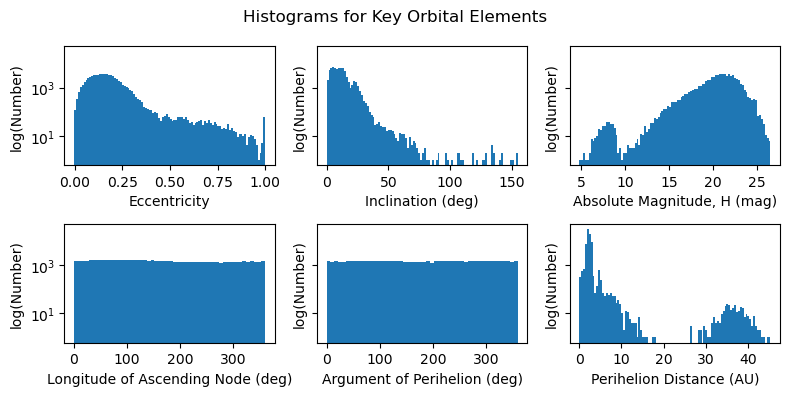

In [70]:
fig, ax = plt.subplots(2, 3, figsize=(8, 4), sharey=True)
ax[0, 0].hist(df['e'], bins=100, log=True)
ax[0, 0].set_xlabel('Eccentricity')
ax[0, 0].set_ylabel('log(Number)')
ax[0, 1].hist(df['incl'], bins=100, log=True)
ax[0, 1].set_xlabel('Inclination (deg)')
ax[0, 1].set_ylabel('log(Number)')
ax[0, 2].hist(df['mpcH'], bins=100, log=True)
ax[0, 2].set_xlabel('Absolute Magnitude, H (mag)')
ax[0, 2].set_ylabel('log(Number)')
ax[1, 0].hist(df['node'], bins=50, log=True)
ax[1, 0].set_xlabel('Longitude of Ascending Node (deg)')
ax[1, 0].set_ylabel('log(Number)')
ax[1, 1].hist(df['peri'], bins=50, log=True)
ax[1, 1].set_xlabel('Argument of Perihelion (deg)')
ax[1, 1].set_ylabel('log(Number)')
ax[1, 2].hist(df['q'], bins=100, log=True)
ax[1, 2].set_xlabel('Perihelion Distance (AU)')
ax[1, 2].set_ylabel('log(Number)')
fig.suptitle('Histograms for Key Orbital Elements')
fig.tight_layout()
plt.show()

## 4. The `SSObject` table

During Rubin Operations, Prompt Processing will occur during the night, detecting sources in 
difference images (`DiaSources`, see Section 6) and associating them into static-sky transients
and variables (`DiaObjects`, not included in DP0.3).

The Solar System Processing which occurs in the daytime, after a night of observing,
links together the `DiaSources` for moving objects into `SSObjects`.
Whereas the `MPCORB` table contains the orbital elements for these moving objects,
the `SSObjects` contains the Rubin-measured properties such as phase curve fits and absolute magnitudes.

> **Notice:** no artifacts or spurious difference-image sources have been injected into the DP0.3 catalogs.

### 4.1. Size

Use the ADQL count function to return the size.

In [67]:
results = service.search("SELECT COUNT(*) from dp03_catalogs.SSObject")
results.to_table().to_pandas()

,COUNT
0,10222593


The DP0.3 data set contains 10.2 million solar system objects detected by Rubin.

This is less than the 14.6 million objects in the `MPCORB` catalog.
It is left as an exercise for the learner in Section 7 to determine the characteristics of those 
objects from the `MPCORB` table are missing from the `SSObject` table.

### 4.2. Columns

**Option:** display a list of column names, data types, descriptions, and units.

In [72]:
# results = service.search("SELECT column_name, datatype, description, unit from TAP_SCHEMA.columns "
#                          "WHERE table_name = 'dp03_catalogs.SSObject'")
# results.to_table().to_pandas()

### 4.3. Retrieve a random subset

Use essentially the same query as was used for the `MPCORB` table, above.

In [73]:
results = service.search("SELECT * FROM dp03_catalogs.ssObject "
                         "WHERE ssObjectId BETWEEN 9131137166374808576 AND 9223370875126069107")
df = results.to_table().to_pandas()

In [74]:
df

,arc,discoverySubmissionDate,firstObservationDate,flags,gChi2,gG12,gG12Err,gH,gH_gG12_Cov,gHErr,...,yH_yG12_Cov,yHErr,yNdata,zChi2,zG12,zG12Err,zH,zH_zG12_Cov,zHErr,zNdata
0,3089.883301,60599.295358,60592.295358,0,1.577042,0.338602,0.202955,21.161713,0.019386,0.106775,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
1,15.927057,61750.270241,61743.270241,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2.961222,62806.302010,62799.302010,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0.000000,61654.218500,61647.218500,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
4,3270.825439,60509.383445,60502.383445,0,1.676326,0.051856,0.138421,18.936575,0.018925,0.141764,...,NaN,NaN,0,1.403565,0.171461,0.162144,18.205658,0.016147,0.108125,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51223,3371.791992,60231.321519,60224.321519,0,4.592573,-0.060991,0.727745,20.432423,0.524340,0.738144,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
51224,7.022134,60968.147893,60961.147893,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
51225,3071.890625,60495.238170,60488.238170,0,1.098199,0.014991,0.073796,20.547508,0.004406,0.065489,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
51226,2400.992676,60533.149470,60526.149470,0,1.070196,0.354199,0.155204,20.241318,0.018267,0.120746,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0


There are 51228 rows.

**Options:** use the `info` or `describe` functions on the `pandas` dataframe to learn more about the retrieved results.

In [ ]:
# df.info()

In [ ]:
# df.describe()

### 4.4. Plot a color-color diagram

In the displayed dataframe above, it appears that for many `SSObjects` the phase-curve fits to derive 
absolute magnitudes were not successful, as the `<f>H` (where `<f>` is a filter u, g, r, i, z, or y) are `NaN`.

Before calculating and plotting the colors, drop all of the rows for which the phase-curve fits were not successful.

In [84]:
df.dropna(inplace=True)
df.reset_index(inplace=True)
print('Number of rows after dropping all rows with NaNs: %d' % len(df))

Number of rows after dropping all rows with NaNs: 4774


For Solar System objects, absolute magnitudes are defined to be for an object 1 AU from the Sun and 1 AU 
from the observer, and at a phase angle (the angle Sun-object-Earth) of 0 degrees.

Absolute magnitudes are derived by correcting for distance, fitting a function to the relationship between 
absolute magnitude and phase, and evaluating the function at a phase of 0 deg.

The process for fitting phase curves will be covered in another tutorial.

Calculate colors in the Rubin filters for the `SSObjects` that have absolute magnitudes.

In [85]:
df['ug'] = df['uH'] - df['gH']
df['gr'] = df['gH'] - df['rH']
df['ri'] = df['rH'] - df['iH']
df['iz'] = df['iH'] - df['zH']
df['zy'] = df['zH'] - df['yH']

Plot color-color diagrams as 2-dimensional histograms (heatmaps).

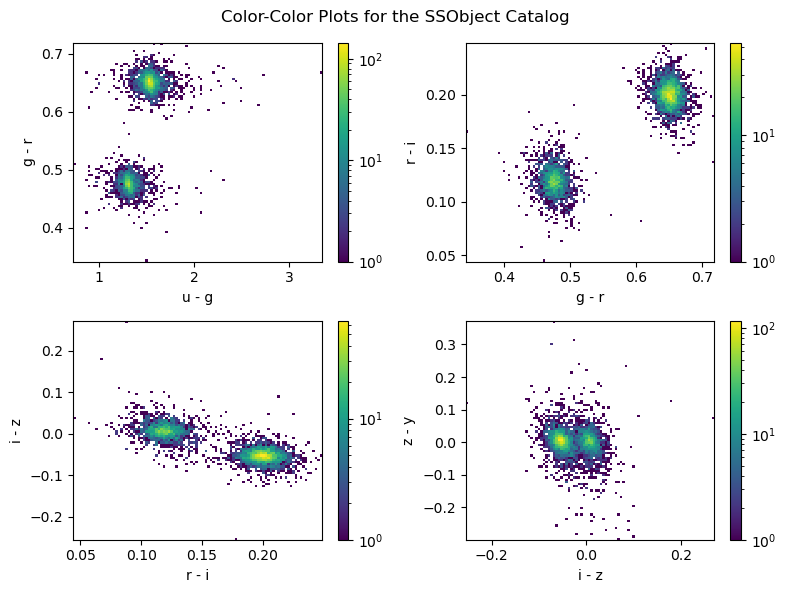

In [94]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
h = ax[0, 0].hist2d(df['ug'], df['gr'], bins=100, norm='log')
ax[0, 0].set_xlabel('u - g')
ax[0, 0].set_ylabel('g - r')
plt.colorbar(h[3])
h = ax[0, 1].hist2d(df['gr'], df['ri'], bins=100, norm='log')
ax[0, 1].set_xlabel('g - r')
ax[0, 1].set_ylabel('r - i')
plt.colorbar(h[3])
h = ax[1, 0].hist2d(df['ri'], df['iz'], bins=100, norm='log')
ax[1, 0].set_xlabel('r - i')
ax[1, 0].set_ylabel('i - z')
plt.colorbar(h[3])
h = ax[1, 1].hist2d(df['iz'], df['zy'], bins=100, norm='log')
ax[1, 1].set_xlabel('i - z')
ax[1, 1].set_ylabel('z - y')
plt.colorbar(h[3])
fig.suptitle('Color-Color Plots for the SSObject Catalog')
fig.tight_layout()
plt.show()

There are only two populations of colors in the simulation - but this is not the case for real Solar System objects.
These plots will look very different in the future, when they are made with real Rubin data.

## 5. The `SSSource` table

As described above, Solar System Processing links together the `DiaSources` (detections in the
individual difference images) from moving objects into `SSObjects`. 

The `SSSource` table contains the 2-d (sky) coordinates and 3-d distances and velocities 
for every `SSObject` at the time of every LSST observation of that `SSObject`.
The `SSSource` and `DiaSource` tables are 1:1, as they each contain data *per observation*,
whereas `SSObject` contains data *per object*.

### 5.1. Size

It can take up to a minute to retrive the size of the `SSSource` catalog.

In [96]:
results = service.search("SELECT COUNT(*) from dp03_catalogs.SSSource")
results.to_table().to_pandas()

,COUNT
0,1031389589


**_This table contains over a billion sources!_**

### 5.2. Columns

**Option:** print the column information for the `SSSource` table.

In [97]:
# results = service.search("SELECT column_name, datatype, description, unit from TAP_SCHEMA.columns "
#                          "WHERE table_name = 'dp03_catalogs.SSSource'")
# results.to_table().to_pandas()

### 5.3. Retrieve data for one `SSObject`

It is possible to obtain the `SSSource` data for a population of `SSObjects`.
For example, to retrieve all `SSSources` for the `SSObjects` retrieved in Section 4,
use a query such as: 

```
SELECT * FROM dp03_catalogs.SSSource
WHERE ssObjectId BETWEEN 9214147504250943488 AND 9223370875126069107
```

However, the better way to demonstrate the data in the `SSSource` table is to look at just one `SSObject`,
and the one with an `ssObjectId` = `6793512588511170680` is a fun choice.

Retrieve the heliocentric (sun-centered) and topocentric (observatory-centered) X and Y coordinates.

In [107]:
df_xy = service.search("SELECT heliocentricX, heliocentricY, topocentricX, "
                       "topocentricY, ssObjectId "
                       "FROM dp03_catalogs.SSSource "
                       "WHERE ssObjectId = 6793512588511170680 ").to_table().to_pandas()
print('Retrieved ', len(df_xy), ' rows.')

Retrieved  487  rows.


**Options** to display the table in full or use the `info` or `describe` functions.

In [101]:
# df_xy

In [103]:
# df_xy.info()

In [105]:
# df_xy.describe()

### 5.3. Plot the orbit of one `SSObject`

Plot the orbit using the X and Y heliocentric (Sun-centered; orange star) 
and topocentric (observatory-centered; blue circle) coordinates.
This is a projection of the orbit into the plane of the Solar System.

Notice how the points are not regularly spaced.
This is because there is one point per LSST observation of the object,
and in some years it recieves more or fewer observations.

Notice how the points appear in an ellipse around the Sun with heliocentric coordinates (left).
This is as it should be, as the object orbits the sun.
The plot of the topocentric coordinates (right) does not appear elliptical because
the motion of the Earth with respect to the object over the 10 years of the LSST
is imprinted into the data. 
Tor the topocentric coordinates, the Earth's rotation also contributes, 
but it is a much smaller effect on the scale of these plots.

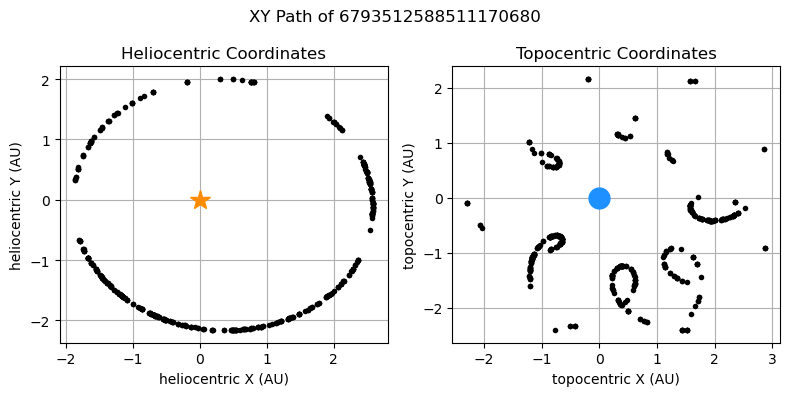

In [129]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].grid()
ax[0].plot(df_xy['heliocentricX'], df_xy['heliocentricY'], 'o', ms=4, mew=0, color='black')
ax[0].plot(0, 0, '*', ms=15, color='darkorange')
ax[0].set_xlabel('heliocentric X (AU)')
ax[0].set_ylabel('heliocentric Y (AU)')
ax[0].set_title('Heliocentric Coordinates')
ax[1].grid()
ax[1].plot(df_xy['topocentricX'], df_xy['topocentricY'], 'o', ms=4, mew=0, color='black')
ax[1].plot(0, 0, 'o', ms=15, color='dodgerblue')
ax[1].set_xlabel('topocentric X (AU)')
ax[1].set_ylabel('topocentric Y (AU)')
ax[1].set_title('Topocentric Coordinates')
fig.suptitle('XY Path of 6793512588511170680')
fig.tight_layout()
plt.show()

## 6. The `DiaSource` catalog

Last but definitely not least, the `DiaSource` table - which is actually the first to be generated
by the Prompt Processing pipeline.
This table will contain measurements for all sources detected with a signal-to-noise ratio of at least 5 
in a difference image, including moving and static-sky sources.

However, for simulated DP0.3 the `DiaSource` table contains *only moving objects*, and no static sky time-domain objects (and no detector artifacts).

For DP0.3 the simulated `DiaSource` table contains only a subset of the columns that the
real `DiaSource` table will have; see Table 1 of the Rubin 
<a href="https://docushare.lsstcorp.org/docushare/dsweb/Get/LSE-163/LSE-163_DataProductsDefinitionDocumentDPDD.pdf">Data Products Definitions Document</a>.
Furthermore, the `DiaSource` table contains a few extra truth columns, such as `raTrue`, `decTrue`, `magTrue`.

For DP0.3, no photometric variability due to, e.g., the rotation of non-spherical bodies, collisions,
or outgassing events were simulated. 
All evolution in apparent magnitudes with time are due to the phase curve, which is explored
in another tutorial.

### 6.1. Size

**Option** to retrieve the size of the `DiaSource` table (it is 1:1 with the `SSSource` table, so the same size).

In [131]:
# results = service.search("SELECT COUNT(*) from dp03_catalogs.DiaSource")
# results.to_table().to_pandas()

### 6.2. Columns

**Option** to print the column information.

In [133]:
# results = service.search("SELECT column_name, datatype, description, unit from TAP_SCHEMA.columns "
#                          "WHERE table_name = 'dp03_catalogs.DiaSource'")
# results.to_table().to_pandas()

### 6.3. Retrieve data for one `SSObject`

It is possible to obtain the `DiaSource` data for a population of `SSObjects`.
For example, to retrieve all `DiaSources` for the `SSObjects` retrieved in Section 4,
use a query such as: 

```
SELECT * FROM dp03_catalogs.DiaSource
WHERE ssObjectId BETWEEN 9214147504250943488 AND 9223370875126069107
```

However, the better way to demonstrate the data in the `DiaSource` table is to look at just one `SSObject`.
As in Section 5, use the one with an `ssObjectId` = `6793512588511170680`.

Retrive the right ascension, declination, magnitude, filter, and the <a href="https://en.wikipedia.org/wiki/International_Atomic_Time">TAI</a> at the exposure's midpoint (MJD) of the observation.

In [136]:
df = service.search("SELECT ra, decl, mag, filter, midPointTai "
                    "FROM dp03_catalogs.DiaSource "
                    "WHERE ssObjectId = 6793512588511170680").to_table().to_pandas()

### 6.4. Plot time-domain data for one `SSObject`

First, plot the equatorial coordinates for all observations, colored by the MJD of the observation.

This plot shows the location of the object on the sky, as seen from Earth.
Recall from the plots in Section 5 that this object is only about 2 AU from the Sun,
and so is at the inner edge of the Main Asteroid Belt.
Parallax from the Earth's orbit contributes to the appearance of this plot.

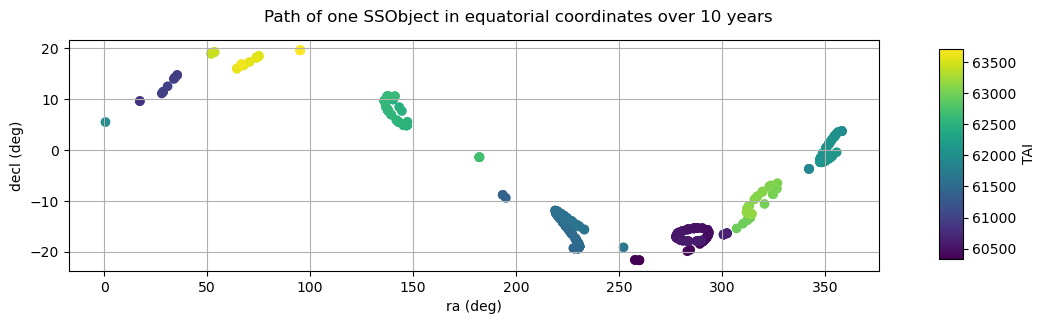

In [142]:
cmap = colormaps['viridis']
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
im = ax.scatter(df['ra'], df['decl'], c=df['midPointTai'], cmap=cmap)
ax.set_xlabel('ra (deg)')
ax.set_ylabel('decl (deg)')
fig.suptitle("Path of one SSObject in equatorial coordinates over 10 years")
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='TAI')
ax.grid(True)

Use of the magnitude and filter data retrieved from the `DiaSource` table is left as
an exercise for the learner in Section 7.

## 7. Exercises for the learner


**1. Which moving objects in the MPC did LSST not detect?**

The `MPCORB` table contains all of the moving objects ever reported to the MPC,
whereas the `SSObject` table contains all of the moving objects detected by LSST.
Which populations of moving objects does LSST not detect?

**2. How does an SSObject's magnitude change with time?**

In Section 6.4, the magnitude and filter for all detections of the `SSObject` in the
`DiaSource` table were retrieved, but not plotted, so make that plot.
Note that the only simulated cause of photometric changes in DP0.3 objects is the phase curve,
and so magnitude vs. phase is the more interesting and useful plot to make.
Phase curves are covered in another tutorial.